### Imports

In [127]:
import numpy as np
import cv2
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import math
# from sklearn.model_selection import train_test_split


### Setup

### Download the dataset and understand the format (10 points)

In [2]:
def generate_ds():
    arr = []
    labels = []
    for i in range(1,41):
        for j in range(1,11):
            path = 's' + str(i) + '/' + str(j) + '.pgm'
            labels.append(i)
            arr.append(cv2.imread(path,-1).flatten())
    return np.array(arr), np.array(labels)

### Generate the Data Matrix and the Label vector(10 Points)


In [19]:
X, y = generate_ds()
print(f"Input features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Input features shape: (400, 10304)
Labels shape: (400,)


### Split the Dataset into Train and Test sets (10 Points)

In [129]:
def train_test_split(matrix, labels):
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    even = True
    for data, label in zip(matrix, labels):
        if even:
            train_data.append(data)
            train_labels.append(label)
        else:
            test_data.append(data)
            test_labels.append(label)
        even = not even

    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)

In [20]:
# X, y = generate_ds()
X_train, y_train, X_test, y_test = train_test_split(X,y)

In [21]:
X_train.shape

(200, 10304)

In [22]:
np.mean(X_train,axis=0).shape

(10304,)

### Classification using PCA (30 points)

In [23]:
class PCA:
    def __init__(self, train_data, alpha):
        self.X = train_data
        self.alpha = alpha
        self.trained = False

    def find_values(self):
        print("Finding top n eigen values to reach alpha ({}): ..".format(self.alpha), end=' ')
        sum = 0
        r = 0
        for i,val in enumerate(self.eigen_values):
            sum+=val
            if (sum/self.total_variance)>=self.alpha:
                r = i+1
                break
        print('Done. -- Found top {} eigen values reach {} variance.'.format(r, sum/self.total_variance))

        return r
    
    def update_alpha(self, alpha):
        self.alpha = alpha
        if self.trained:
            r = self.find_values()
            self.U = self.eigen_vectors[:,:r]
            self.A = self.X.dot(self.U)
    
    def train(self):
        print("Calculating mu: ..", end=' ')
        self.mu = np.mean(self.X, axis=0)
        print('Done.')
        print("Calculating Z: ..", end=' ')
        self.Z = self.X - 1*np.transpose(self.mu)
        print('Done.')
        print("Calculating covariance matrix: ..", end=' ')
        # cov = np.cov(Z, rowvar=False,bias=True)
        cov = (np.transpose(self.Z) @ self.Z) / self.Z.shape[0]
        print('Done.')
        print("Calculating eigen vectors and values: ..", end=' ')
        x,y = np.linalg.eigh(cov)
        # y = y.real.astype(np.float32)
        print('Done.')
        print("Sorting eigen vectors and values: ..", end=' ')
        # self.eigen_values, eigen_vectors = zip(*sorted(zip(x,y), reverse=True)) # sorts eigen values and eigen vectors based on eigen values
        
        idx = x.argsort()[::-1]   
        self.eigen_values = x[idx]
        eigen_vectors = y[:,idx]
            
        self.eigen_vectors = np.array(eigen_vectors)
        print('Done.')
        print("Calculating sum of eigen vectors: ..", end=' ')
        self.total_variance = np.sum(self.eigen_values)
        print('Done. -- eigen vectors shape: {}'.format(self.eigen_vectors.shape))
        r = self.find_values()
        self.U = self.eigen_vectors[:,:r]
        # self.A = np.array([np.transpose(self.U)@x for x in self.Z])
        self.A = self.X.dot(self.U)
        self.trained = True

    def project_point(self, p):
        if not self.trained:
            return None
        return np.transpose(self.U)@(p)
    
    def transform(self,X_test):
        return (X_test).dot(self.U)

In [26]:
class KNN:
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def most_frequent(self, arr):
        return max(set(arr), key=arr.count)

    def predict(self, X_new):
        self.y_pred = []
        for x1 in X_new:
            euclidean_dist = []
            for i, x2 in enumerate(self.X_train):
                norm = np.linalg.norm(x1-x2)
                euclidean_dist.append([norm, i])
            euclidean_dist.sort()
            vote_idx = euclidean_dist[:self.n_neighbors]
            votes = [self.y_train[n] for _, n in vote_idx]
            final_vote = self.most_frequent(votes)
            self.y_pred.append(final_vote)
        return self.y_pred


In [140]:
pca = PCA(X_train,0.80)
pca.train()

Calculating mu: .. Done.
Calculating Z: .. Done.
Calculating covariance matrix: .. Done.
Calculating eigen vectors and values: .. Done.
Sorting eigen vectors and values: .. Done.
Calculating sum of eigen vectors: .. Done. -- eigen vectors shape: (10304, 10304)
Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 36 eigen values reach 0.8033355576765808 variance.


Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 36 eigen values reach 0.8033355576765808 variance.
alpha = 0.8 accuracy = 95.0%
Finding top n eigen values to reach alpha (0.85): .. Done. -- Found top 51 eigen values reach 0.8503691004202292 variance.
alpha = 0.85 accuracy = 95.0%
Finding top n eigen values to reach alpha (0.9): .. Done. -- Found top 76 eigen values reach 0.9012199076267524 variance.
alpha = 0.9 accuracy = 94.0%
Finding top n eigen values to reach alpha (0.95): .. Done. -- Found top 115 eigen values reach 0.9500956623671027 variance.
alpha = 0.95 accuracy = 94.0%


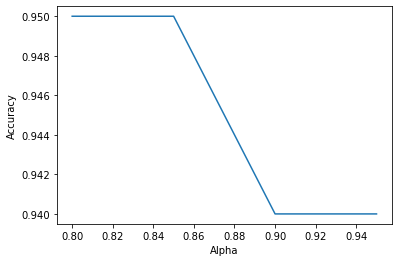

In [24]:
alphas = [0.8,0.85,0.9,0.95]
accuracies = []
for i, alpha in enumerate(alphas):
    knn = KNeighborsClassifier(n_neighbors=1)
    pca.update_alpha(alpha)
    knn.fit(pca.A.real, y_train)
    y_pred = knn.predict((pca.transform(X_test).real))
    accuracies.append(accuracy_score(y_pred, y_test))
    print(f"alpha = {alpha} accuracy = {accuracies[i]*100}%")
plt.plot(alphas, np.array(accuracies))
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()

Finding top n eigen values to reach alpha (0.2): .. Done. -- Found top 2 eigen values reach 0.3068864150819098 variance.
alpha = 0.2 accuracy = 43.0%
Finding top n eigen values to reach alpha (0.3): .. Done. -- Found top 2 eigen values reach 0.3068864150819098 variance.
alpha = 0.3 accuracy = 43.0%
Finding top n eigen values to reach alpha (0.4): .. Done. -- Found top 4 eigen values reach 0.43797809144174593 variance.
alpha = 0.4 accuracy = 75.0%
Finding top n eigen values to reach alpha (0.5): .. Done. -- Found top 6 eigen values reach 0.5221659929137248 variance.
alpha = 0.5 accuracy = 85.5%
Finding top n eigen values to reach alpha (0.6): .. Done. -- Found top 10 eigen values reach 0.6117654690506844 variance.
alpha = 0.6 accuracy = 92.0%
Finding top n eigen values to reach alpha (0.7): .. Done. -- Found top 18 eigen values reach 0.7030021594920808 variance.
alpha = 0.7 accuracy = 93.5%
Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 36 eigen values reach 0.80

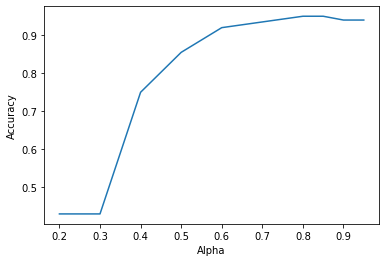

In [25]:
alphas = [0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.85, 0.9, 0.95]
accuracies = []
for i, alpha in enumerate(alphas):
    knn = KNeighborsClassifier(n_neighbors=1)
    pca.update_alpha(alpha)
    knn.fit(pca.A.real, y_train)
    y_pred = knn.predict((pca.transform(X_test).real))
    accuracies.append(accuracy_score(y_pred, y_test))
    print(f"alpha = {alpha} accuracy = {accuracies[i]*100}%")
plt.plot(alphas, np.array(accuracies))
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()


#### e. Can you find a relation between alpha and classification accuracy?
In general, accuracy increases as alpha increases. However, the accuracy fluctuated a little near the end. This may be due to the fact that some part of the variance is pure noise and not useful distictive information.

In [138]:
def show_eigenfaces(U):
  plt.figure(figsize=(20, 10))
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(U[:, i].reshape(112, 92), cmap='gray')
  plt.show()


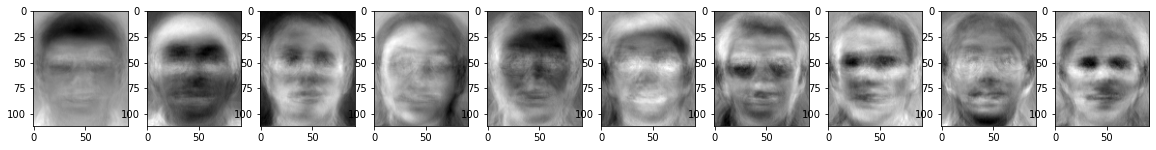

In [141]:
show_eigenfaces(pca.U)

### Classifier Tuning - PCA (20 Points)

Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 36 eigen values reach 0.8033355576765808 variance.
k = 1	 accuracy = 95.0%
k = 3	 accuracy = 89.0%
k = 5	 accuracy = 84.5%
k = 7	 accuracy = 80.0%


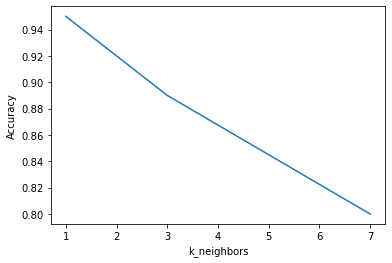

In [32]:
k_neighbors = np.arange(1,8,2)
pca.update_alpha(0.8)
accuracies = []
for i,k in enumerate(k_neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(pca.A.real,y_train)
    y_pred = knn.predict((pca.transform(X_test).real))
    accuracies.append(accuracy_score(y_pred,y_test))
    print(f"k = {k}\t accuracy = {accuracies[i]*100}%")
plt.plot(k_neighbors,accuracies)
plt.xlabel('k_neighbors')
plt.ylabel('Accuracy')
plt.show()
    
    

k = 1	accuracy = 95.0%
k = 3	accuracy = 89.5%
k = 5	accuracy = 83.0%
k = 7	accuracy = 76.5%


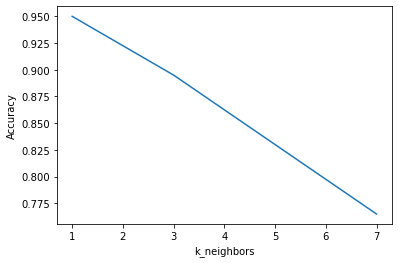

In [33]:
k_neighbors = np.arange(1,8,2)
accuracies = []
for i,k in enumerate(k_neighbors):
    knn = KNN(n_neighbors=k)
    knn.fit(pca.A,y_train)
    y_pred = knn.predict((pca.transform(X_test)))
    accuracies.append(accuracy_score(y_pred,y_test))
    print(f"k = {k}\taccuracy = {accuracies[i]*100}%")
plt.plot(k_neighbors, accuracies)
plt.xlabel('k_neighbors')
plt.ylabel('Accuracy')
plt.show()


### Classification Using LDA (30 Points)

In [112]:
import scipy
class LDA:
    def __init__(self,train_data,labels,n_components=39):
        self.X = train_data
        self.labels = labels
        self.n_components = n_components
        self.trained = False 
        
    def update_n_components(self,n):
        if self.trained == True:
            self.n_components = n
            self.U = self.eigen_vectors[:,:self.n_components+1]   
            self.A = self.X.dot(self.U)
        
    
    def fit(self):
        n_features = self.X.shape[1]
        # between class scatter matrix
        Sb = np.zeros((n_features,n_features))
        S = np.zeros((n_features,n_features))
        total_mu = np.mean(self.X,axis=0)
        classes = np.unique(self.labels)
        for label in classes:
            X_k = self.X[self.labels==label]
            mu_k = np.mean(X_k,axis=0)
            n_k = X_k.shape[0]
            xx = (mu_k - total_mu).reshape(-1,1)
            # Sb += n_k * (xx.dot(xx.T))
            Sb += n_k * np.dot(xx,xx.T)
            Z_k = X_k - mu_k.reshape(-1,1).T
            S_k = Z_k.T @ Z_k
            S += S_k
        temp = np.dot(np.linalg.inv(S),Sb)
        x,y = np.linalg.eigh(temp)
        # x,y = scipy.linalg.eig(temp)
        idx = x.argsort()[::-1]   
        self.eigen_values = x[idx]
        eigen_vectors = y[:,idx]
        self.eigen_vectors = np.array(eigen_vectors)
        self.U = self.eigen_vectors[:,:self.n_components+1]   
        self.A = self.X.dot(self.U)
        self.trained = True
        
    def transform(self,X_new):
        return X_new.dot(self.U)


In [135]:
lda=LDA(X_train,y_train)
lda.fit()

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
ldaa = LinearDiscriminantAnalysis(n_components=39)
ldaa.fit(X_train,y_train)
y_pred = ldaa.predict(X_test)
print(accuracy_score(y_pred,y_test))

0.945


In [136]:
accuracy = 0
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(lda.A.real, y_train)
y_pred = knn.predict((lda.transform(X_test).real))
accuracy = accuracy_score(y_pred, y_test)
print(f"n_components = 39 accuracy = {accuracy*100}%")

n_components = 39 accuracy = 92.5%


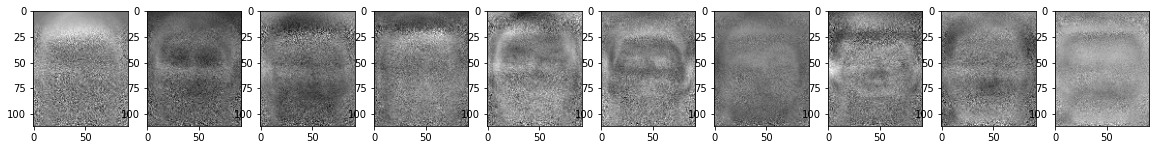

In [139]:
show_eigenfaces(lda.U)

#### Comparison between PCA and LDA
Results show that PCA outperforms LDA. This is due to the fact that LDA depends on class separability during dimensionality reduction, and the number of objects per class in this dataset is small.

### Classifier Tuning - LDA (20 Points)

k = 1	 accuracy = 92.5%
k = 3	 accuracy = 88.5%
k = 5	 accuracy = 85.0%
k = 7	 accuracy = 81.0%


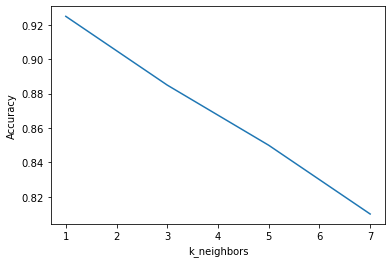

In [45]:
k_neighbors = np.arange(1, 8, 2)
lda.update_n_components(39)
accuracies = []
for i, k in enumerate(k_neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(lda.A.real, y_train)
    y_pred = knn.predict((lda.transform(X_test).real))
    accuracies.append(accuracy_score(y_pred, y_test))
    print(f"k = {k}\t accuracy = {accuracies[i]*100}%")
plt.plot(k_neighbors, accuracies)
plt.xlabel('k_neighbors')
plt.ylabel('Accuracy')
plt.show()


### Compare vs Non-Face Images - PCA (15 Points)

In [46]:
import os
def load_non_faces(folder, lim=np.inf):
    images = []
    labels = []
    for file in os.listdir(folder):
        if len(labels)>=lim:
            break
        img=cv2.imread(os.path.join(folder,file),0)
        img_resized =cv2.resize(img, (92,112))
        images.append(img_resized.flatten())
        labels.append(0)
    return np.array(images),np.array(labels)

#### Trying a non_faces dataset with 8 distinct classes

In [47]:
images,labels_non = load_non_faces("./non_faces")

In [48]:
print(labels_non.shape)
print(images.shape)

(400,)
(400, 10304)


In [49]:
# np.random.shuffle(images)
dataset = np.append(X,images,axis=0)


In [50]:
labels_faces = np.ones([400,1])
data_labels = np.append(labels_faces,labels_non).astype(int)
data_labels.shape

(800,)

In [51]:
X_train_new, y_train_new, X_test_new, y_test_new = train_test_split(dataset,data_labels)

In [52]:
pca = PCA(X_train_new,0.8)
pca.train()

Calculating mu: .. Done.
Calculating Z: .. Done.
Calculating covariance matrix: .. Done.
Calculating eigen vectors and values: .. Done.
Sorting eigen vectors and values: .. Done.
Calculating sum of eigen vectors: .. Done. -- eigen vectors shape: (10304, 10304)
Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 37 eigen values reach 0.8028936614044903 variance.


In [53]:
def get_cases(y_pred, y_test):
    success = []
    fail = []
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            success.append(i)
        else:
            fail.append(i)

    return success, fail

In [57]:
alphas = [0.8,0.85,0.9,0.95]
accuracies = []
for i,a in enumerate(alphas):
    pca.update_alpha(a)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(pca.A.real,y_train_new)
    y_pred = knn.predict((pca.transform(X_test_new).real))
    accuracies.append(accuracy_score(y_pred,y_test_new))
    print(f"alpha = {a}\taccuracy = {accuracies[i]*100}%")

Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 37 eigen values reach 0.8028936614044903 variance.
alpha = 0.8	accuracy = 91.75%
Finding top n eigen values to reach alpha (0.85): .. Done. -- Found top 57 eigen values reach 0.850984671411977 variance.
alpha = 0.85	accuracy = 91.0%
Finding top n eigen values to reach alpha (0.9): .. Done. -- Found top 92 eigen values reach 0.9009119456118143 variance.
alpha = 0.9	accuracy = 89.0%
Finding top n eigen values to reach alpha (0.95): .. Done. -- Found top 156 eigen values reach 0.9500652613147591 variance.
alpha = 0.95	accuracy = 86.5%


#### Show failure and success cases

In [58]:
success, fail = get_cases(knn.predict((pca.transform(X_test_new).real)), y_test_new)

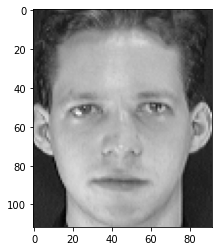

In [59]:
img = np.reshape(X_train_new[success[0]],(112,92))
plt.imshow(img, cmap='gray')
plt.show()

In [60]:
len(success)

346

In [61]:
len(fail)

54

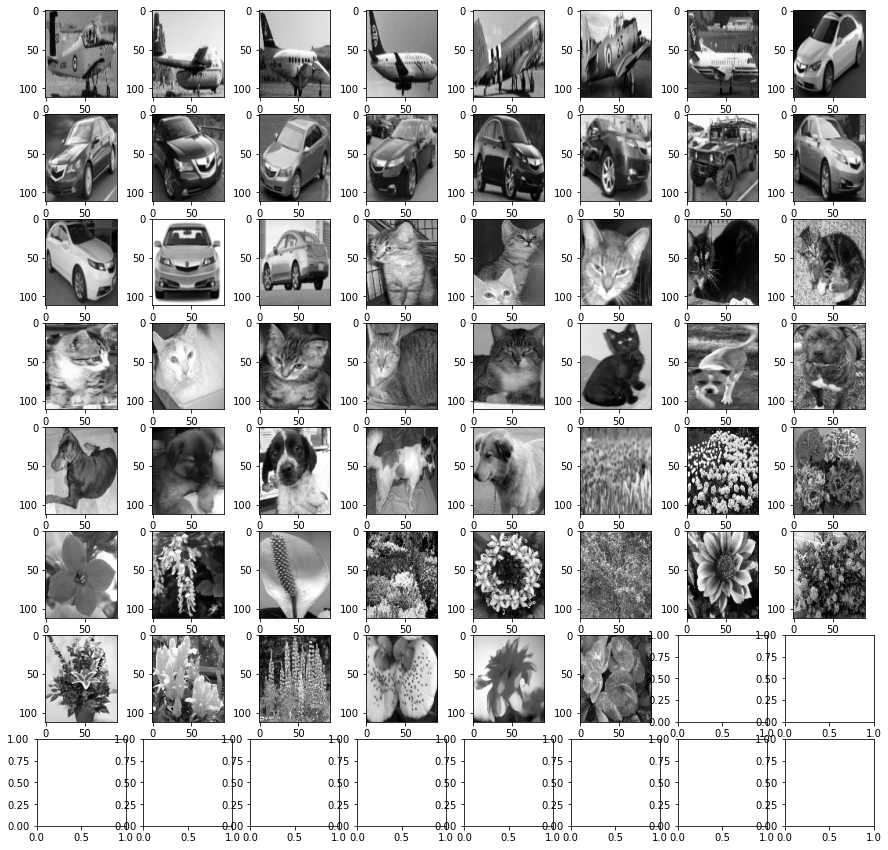

In [64]:
fig, axs = plt.subplots(math.ceil(math.sqrt(len(fail))), math.ceil(math.sqrt(len(fail))),figsize=(15,15))
axs = axs.flatten()

c = 0

for f in fail:
    img = np.reshape(X_train_new[f],(112,92))
    axs[c].imshow(img, cmap='gray')
    c+=1
    # plt.show()

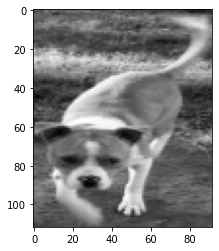

In [65]:
img = np.reshape(X_train_new[fail[30]],(112,92))
plt.imshow(img, cmap='gray')
plt.show()

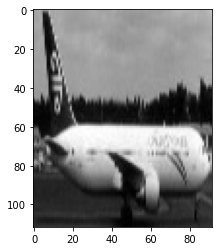

In [66]:
img = np.reshape(X_train_new[209],(112,92))
plt.imshow(img, cmap='gray')
plt.show()

#### Observations
All failure cases were non faces. This shows that since the number of distinct non_faces classes is large, there wasn't enough data to find a similar pattern among them. 

#### Trying a non_faces dataset with only one class

In [73]:
images,labels_non = load_non_faces("./non_faces_2")
dataset = np.append(X, images, axis=0)
labels_faces = np.ones([400, 1])
data_labels = np.append(labels_faces, labels_non).astype(int)
X_train_new, y_train_new, X_test_new, y_test_new = train_test_split(dataset,data_labels)


In [74]:
pca = PCA(X_train_new,0.8)
pca.train()

Calculating mu: .. Done.
Calculating Z: .. Done.
Calculating covariance matrix: .. Done.
Calculating eigen vectors and values: .. Done.
Sorting eigen vectors and values: .. Done.
Calculating sum of eigen vectors: .. Done. -- eigen vectors shape: (10304, 10304)
Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 56 eigen values reach 0.8005340182226445 variance.


In [75]:
alphas = [0.8, 0.85, 0.9, 0.95]
accuracies = []
for i, a in enumerate(alphas):
    pca.update_alpha(a)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(pca.A.real, y_train_new)
    y_pred = knn.predict((pca.transform(X_test_new).real))
    accuracies.append(accuracy_score(y_pred, y_test_new))
    print(f"alpha = {a}\taccuracy = {accuracies[i]*100}%")


Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 56 eigen values reach 0.8005340182226445 variance.
alpha = 0.8	accuracy = 98.57904085257549%
Finding top n eigen values to reach alpha (0.85): .. Done. -- Found top 88 eigen values reach 0.8509988109682269 variance.
alpha = 0.85	accuracy = 98.22380106571936%
Finding top n eigen values to reach alpha (0.9): .. Done. -- Found top 141 eigen values reach 0.9000069210535308 variance.
alpha = 0.9	accuracy = 98.22380106571936%
Finding top n eigen values to reach alpha (0.95): .. Done. -- Found top 246 eigen values reach 0.9500343491747903 variance.
alpha = 0.95	accuracy = 98.04618117229128%


In [76]:
def prep(path, faces, lim):
    images,labels_non = load_non_faces(path, lim=lim)
    dataset = np.append(faces,images,axis=0)
    labels_faces = np.ones([400,1])
    data_labels = np.append(labels_faces,labels_non).astype(int)
    return train_test_split(dataset,data_labels)

#### Accuracy vs number of non-faces

In [77]:
lims = np.arange(100,701,100)
accs = []
for lim in lims:
    X_train_new, y_train_new, X_test_new, y_test_new = prep("./non_faces_2", X, lim)
    pca = PCA(X_train_new,0.8)
    pca.train()
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(pca.A.real,y_train_new)
    y_pred = knn.predict((pca.transform(X_test_new).real))
    accs.append(accuracy_score(y_pred,y_test_new))
    del pca

Calculating mu: .. Done.
Calculating Z: .. Done.
Calculating covariance matrix: .. Done.
Calculating eigen vectors and values: .. Done.
Sorting eigen vectors and values: .. Done.
Calculating sum of eigen vectors: .. Done. -- eigen vectors shape: (10304, 10304)
Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 36 eigen values reach 0.8029961736729959 variance.
Calculating mu: .. Done.
Calculating Z: .. Done.
Calculating covariance matrix: .. Done.
Calculating eigen vectors and values: .. Done.
Sorting eigen vectors and values: .. Done.
Calculating sum of eigen vectors: .. Done. -- eigen vectors shape: (10304, 10304)
Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 40 eigen values reach 0.8032575811436897 variance.
Calculating mu: .. Done.
Calculating Z: .. Done.
Calculating covariance matrix: .. Done.
Calculating eigen vectors and values: .. Done.
Sorting eigen vectors and values: .. Done.
Calculating sum of eigen vectors: .. Done. -- eigen vec

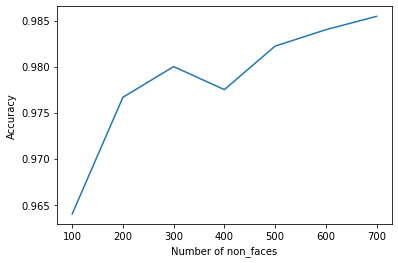

In [78]:
plt.plot(lims,accs)
plt.xlabel("Number of non_faces")
plt.ylabel("Accuracy")
plt.show()

### Compare vs Non-Face Images - LDA (15 Points)

#### Trying a non_faces dataset with 8 distinct classes

In [125]:
images,labels_non = load_non_faces("./non_faces")
dataset = np.append(X,images,axis=0)
labels_faces = np.ones([400, 1])
data_labels = np.append(labels_faces, labels_non).astype(int)
X_train_new, y_train_new, X_test_new, y_test_new = train_test_split(dataset,data_labels)


In [80]:
lda = LDA(X_train_new,y_train_new,n_components=1)
lda.fit()

#### How  many  dominant  eigenvectors  will  you  use  for  the  LDA solution?
Answer:

We will use 1 dominant eigen vector. The number of dominant eigen vectors must not be greater than min(n_classes-1,n_features). Since, we have only 2 classes, n_components=1.

In [92]:
# n_components = [1, 10, 20, 30]
accuracy = 0
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(lda.A.real, y_train_new)
y_pred = knn.predict((lda.transform(X_test_new).real))
accuracy = accuracy_score(y_pred, y_test_new)
print(f"accuracy = {accuracy*100}%")


accuracy = 89.0%


#### Show failure and success cases

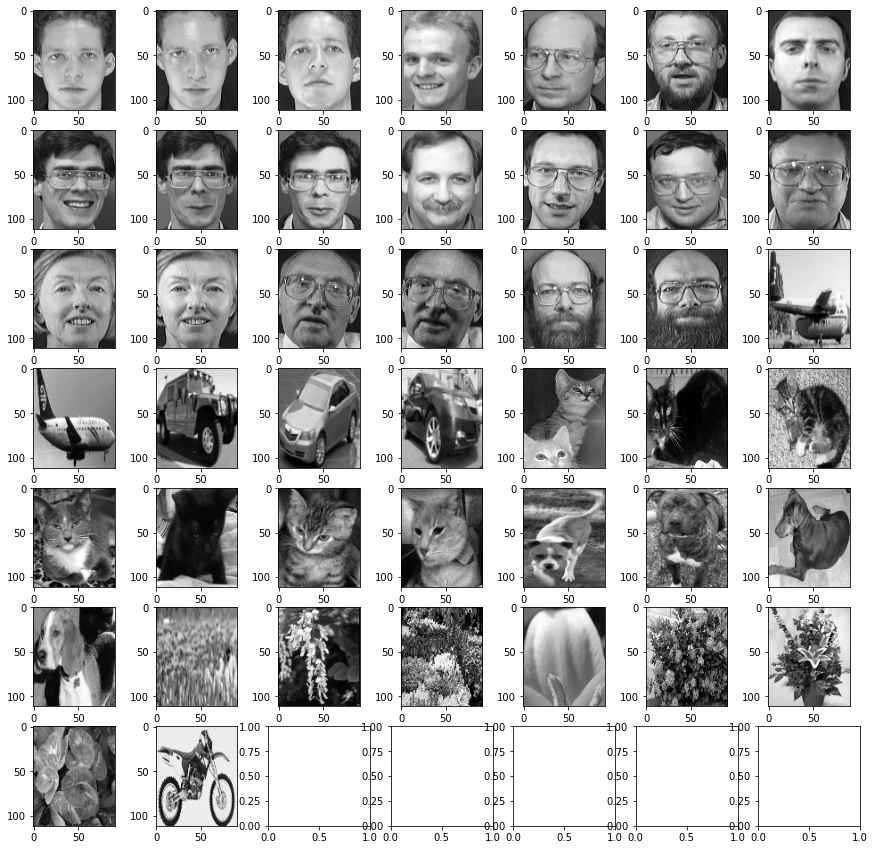

In [94]:
fig, axs = plt.subplots(math.ceil(math.sqrt(len(fail))),
                        math.ceil(math.sqrt(len(fail))), figsize=(15, 15))
axs = axs.flatten()

c = 0

for f in fail:
    img = np.reshape(X_train_new[f], (112, 92))
    axs[c].imshow(img, cmap='gray')
    c += 1
    # plt.show()


#### Trying a non_faces dataset with only one class

In [130]:
lims = np.arange(100,701,100)
accs= []
for lim in lims:
    X_train_new, y_train_new, X_test_new, y_test_new = prep("./non_faces_2", X, lim)
    lda = LDA(X_train_new, y_train_new,n_components=1)
    lda.fit()
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(lda.A.real,y_train_new)
    y_pred = knn.predict((lda.transform(X_test_new).real))
    accs.append(accuracy_score(y_pred,y_test_new))
    del lda

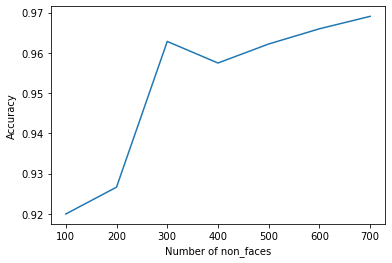

In [134]:
plt.plot(lims, accs)
plt.xlabel("Number of non_faces")
plt.ylabel("Accuracy")
plt.show()

### Bonus (5 Points)

In [161]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3,stratify = y)

In [150]:
pca = PCA(X_train1,0.8)
pca.train()

Calculating mu: .. Done.
Calculating Z: .. Done.
Calculating covariance matrix: .. Done.
Calculating eigen vectors and values: .. Done.
Sorting eigen vectors and values: .. Done.
Calculating sum of eigen vectors: .. Done. -- eigen vectors shape: (10304, 10304)
Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 40 eigen values reach 0.8002298983289385 variance.


Finding top n eigen values to reach alpha (0.8): .. Done. -- Found top 40 eigen values reach 0.8002298983289385 variance.
alpha = 0.8 accuracy = 98.33333333333333%
Finding top n eigen values to reach alpha (0.85): .. Done. -- Found top 60 eigen values reach 0.8504178856953976 variance.
alpha = 0.85 accuracy = 97.5%
Finding top n eigen values to reach alpha (0.9): .. Done. -- Found top 93 eigen values reach 0.9007707270182792 variance.
alpha = 0.9 accuracy = 97.5%
Finding top n eigen values to reach alpha (0.95): .. Done. -- Found top 149 eigen values reach 0.9504193145485883 variance.
alpha = 0.95 accuracy = 97.5%


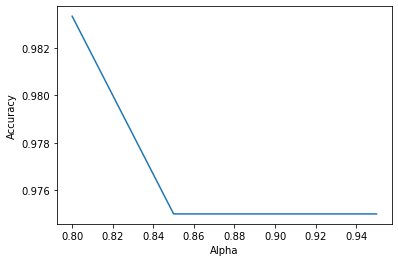

In [151]:
alphas = [0.8, 0.85, 0.9, 0.95]
accuracies = []
for i, alpha in enumerate(alphas):
    knn = KNeighborsClassifier(n_neighbors=1)
    pca.update_alpha(alpha)
    knn.fit(pca.A.real, y_train1)
    y_pred = knn.predict((pca.transform(X_test1).real))
    accuracies.append(accuracy_score(y_pred, y_test1))
    print(f"alpha = {alpha} accuracy = {accuracies[i]*100}%")
plt.plot(alphas, np.array(accuracies))
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()


In [152]:
lda = LDA(X_train1,y_train1)
lda.fit()

In [154]:
accuracy = 0
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(lda.A.real, y_train1)
y_pred = knn.predict((lda.transform(X_test1).real))
accuracy=accuracy_score(y_pred, y_test1)
print(f"accuracy = {accuracy*100}%")

accuracy = 98.33333333333333%


### Bonus (10 points)

In [204]:
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import time


In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,stratify = y)

In [170]:
alphas=[0.8,0.85,0.9,0.95]
accuracies = []
for a in alphas:
    pca = PCA(n_components=a)
    benchmark = time.time()
    pca.fit(X_train)
    elapsed = time.time() - benchmark
    projected_X_train = pca.transform(X_train)
    projected_X_test = pca.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(projected_X_train, y_train)
    y_pred = knn.predict(projected_X_test)
    accuracies.append(accuracy_score(y_pred, y_test))
    print(f"PCA accuracy: {accuracy_score(y_pred, y_test)}")
    print(f"PCA training time: {elapsed} s")


PCA accuracy: 0.94
PCA training time: 0.1495985984802246 s
PCA accuracy: 0.945
PCA training time: 0.1186826229095459 s
PCA accuracy: 0.945
PCA training time: 0.15159320831298828 s
PCA accuracy: 0.95
PCA training time: 0.21143889427185059 s


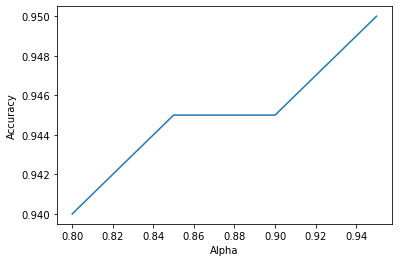

In [171]:
plt.plot(alphas,accuracies)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()


In [184]:
pca = KernelPCA(kernel='poly')
benchmark = time.time()
pca.fit(X_train)
elapsed = time.time() - benchmark
projected_X_train = pca.transform(X_train)
projected_X_test = pca.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(projected_X_train, y_train)
y_pred = knn.predict(projected_X_test)
print(f"Kernel PCA accuracy: {accuracy_score(y_pred, y_test)}")
print(f"Kerel PCA training time: {elapsed} s")


Kernel PCA accuracy: 0.945
Kerel PCA training time: 0.02493572235107422 s


In [189]:
n_components = [10, 20, 30, 40,50,60,70,80,90,100]
accuracies = []
for a in n_components:
    pca = TruncatedSVD(n_components=a)
    benchmark = time.time()
    pca.fit(X_train)
    elapsed = time.time() - benchmark
    projected_X_train = pca.transform(X_train)
    projected_X_test = pca.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(projected_X_train, y_train)
    y_pred = knn.predict(projected_X_test)
    accuracies.append(accuracy_score(y_pred, y_test))
    print(f"Truncated SVD accuracy: {accuracy_score(y_pred, y_test)}")
    print(f"Truncated SVD training time: {elapsed} s")


Truncated SVD accuracy: 0.935
Truncated SVD training time: 0.12366390228271484 s
Truncated SVD accuracy: 0.935
Truncated SVD training time: 0.17852210998535156 s
Truncated SVD accuracy: 0.94
Truncated SVD training time: 0.22440171241760254 s
Truncated SVD accuracy: 0.94
Truncated SVD training time: 0.23640012741088867 s
Truncated SVD accuracy: 0.94
Truncated SVD training time: 0.28819751739501953 s
Truncated SVD accuracy: 0.945
Truncated SVD training time: 0.2064807415008545 s
Truncated SVD accuracy: 0.945
Truncated SVD training time: 0.26030445098876953 s
Truncated SVD accuracy: 0.945
Truncated SVD training time: 0.29720473289489746 s
Truncated SVD accuracy: 0.945
Truncated SVD training time: 0.2792515754699707 s
Truncated SVD accuracy: 0.95
Truncated SVD training time: 0.3121638298034668 s


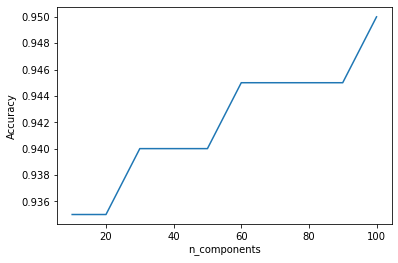

In [190]:
plt.plot(n_components, accuracies)
plt.xlabel("n_components")
plt.ylabel("Accuracy")
plt.show()


In [192]:
n_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracies = []
for a in n_components:
    pca = IncrementalPCA(n_components=a)
    benchmark = time.time()
    pca.fit(X_train)
    elapsed = time.time() - benchmark
    projected_X_train = pca.transform(X_train)
    projected_X_test = pca.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(projected_X_train, y_train)
    y_pred = knn.predict(projected_X_test)
    accuracies.append(accuracy_score(y_pred, y_test))
    print(f"Incremental PCA accuracy: {accuracy_score(y_pred, y_test)}")
    print(f"Incremental PCA training time: {elapsed} s")


Incremental PCA accuracy: 0.93
Incremental PCA training time: 0.5335474014282227 s
Incremental PCA accuracy: 0.935
Incremental PCA training time: 0.24235153198242188 s
Incremental PCA accuracy: 0.94
Incremental PCA training time: 0.2074446678161621 s
Incremental PCA accuracy: 0.94
Incremental PCA training time: 0.25830864906311035 s
Incremental PCA accuracy: 0.945
Incremental PCA training time: 0.20847511291503906 s
Incremental PCA accuracy: 0.945
Incremental PCA training time: 0.16655230522155762 s
Incremental PCA accuracy: 0.945
Incremental PCA training time: 0.1904911994934082 s
Incremental PCA accuracy: 0.945
Incremental PCA training time: 0.1655583381652832 s
Incremental PCA accuracy: 0.945
Incremental PCA training time: 0.2054142951965332 s
Incremental PCA accuracy: 0.945
Incremental PCA training time: 0.2283954620361328 s


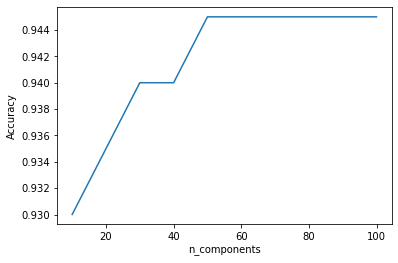

In [193]:
plt.plot(n_components, accuracies)
plt.xlabel("n_components")
plt.ylabel("Accuracy")
plt.show()


In [195]:
lda = LinearDiscriminantAnalysis(solver='svd')
benchmark = time.time()
lda.fit(X_train, y_train)
elapsed = time.time() - benchmark
projected_X_train = lda.transform(X_train)
projected_X_test = lda.transform(X_test)
knn = KNeighborsClassifier()
knn.fit(projected_X_train, y_train)
y_pred = knn.predict(projected_X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"LDA accuracy: {accuracy}")
print(f"LDA training time: {elapsed}")

LDA accuracy: 0.93
LDA training time: 0.3390929698944092


In [210]:
qda = QuadraticDiscriminantAnalysis()
benchmark = time.time()
qda.fit(X_train, y_train)
elapsed = time.time() - benchmark
y_pred = qda.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"QDA accuracy: {accuracy}")
print(f"QDA training time: {elapsed}")

d:\Users\ranab\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA accuracy: 0.085
QDA training time: 0.07579779624938965
